# Autoencoders

Autoencoders are a specific architecture of neural networks and are used in a variety of use cases, such as noise reduction or outlier detection, but they also provide a quick way to use neural networks in a generative manner.
This is achived by training a neural network which reduces the input to a *latent space* (a vector-space with much less dimensions than our input data) in the *encoder* and a *decoder* which tries to recreate the data from the latent space to its original form.

![Scheme of an autoencoder](https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)

[https://commons.wikimedia.org/wiki/File:Autoencoder_schema.png](https://commons.wikimedia.org/wiki/File:Autoencoder_schema.png)

Opposed to the other neural network architectures we do not need any kind of labeleled data - we only need the input data and the neural networks tries to find the corelational semantics within the data.
This is also often helpful if you have lots of data but not many examples with labels as this allows the neural network to find the structure in the data and so it can learn the labels easier and therefore on a subset.

As our MNIST dataset contains $28 \times 28$ dimensional images we can try to reduce the data to a 2 dimensional representation in our latentspace.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

As before we will load the mnist data and scale it for easier training.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# add dim b/c of convolution
# scale data from [0,255] to [0,1]
x_train_cnn = x_train[:, :, :, np.newaxis] / 255.0
x_test_cnn = x_test[:, :, :, np.newaxis] / 255.0

For the encoder we will use an architecture like in our convolutional example, except we will replace the max pooling layers with strides.

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2),
], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 234,274
Trainable params: 234,274
Non-trainab

2021-12-05 20:37:45.766107: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    # we want this layer to have the same dimension as the first dense layer
    # so we can go "backwards" as we have gone "forwards"
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(7*7*64),
    # reshape from a vector to a multidimensional array (image)
    tf.keras.layers.Reshape((7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    # back to the 1 dimensional black/white image
    tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='leaky_relu'),
], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 3136)              203840    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       65600     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       32800     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        513 

Now lets create a new model which connects the encoder output with the decoder output.

In [ ]:
autoencoder = tf.keras.models.Model(encoder.input, decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 

The loss function which tells us how good the recontstruction of the image works is quite easy.
Let $I$ be our original image and $I'$ our reconstructed image.
The loss function $l$ is then defined by

$$
l: (28 \times 28) \times (28 \times 28) \rightarrow \mathbb{R} \Rightarrow \text{loss}(I, I') = (I - I')^2
$$

In [ ]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]),
)

In [ ]:
autoencoder.fit(
    x=x_train_cnn,
    # use the input as the target
    y=x_train_cnn,
    batch_size=200,
    shuffle=True,
    epochs=5,
)

Epoch 1/5
300/300 [==============================] - 32s 105ms/step - loss: 0.0567
Epoch 2/5
300/300 [==============================] - 30s 98ms/step - loss: 0.0488
Epoch 3/5
300/300 [==============================] - 30s 101ms/step - loss: 0.0465
Epoch 4/5
300/300 [==============================] - 31s 105ms/step - loss: 0.0456
Epoch 5/5
300/300 [==============================] - 34s 113ms/step - loss: 0.0449


In [ ]:
autoencoder.evaluate(x_test_cnn, x_test_cnn)

313/313 [==============================] - 6s 17ms/step - loss: 0.0441


0.04407341778278351

Lets try to reconstruct some images and compare it with the original image that acted as the input for the model.
As always, we will use the 

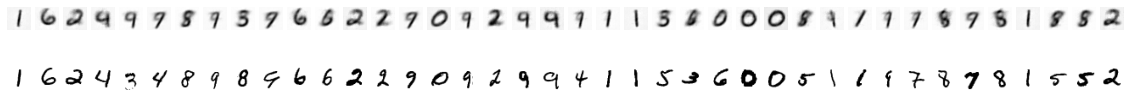

In [ ]:
ae_rand_idxs = np.random.randint(0, x_test_cnn.shape[0], 40)
ae_test_images = x_test_cnn[ae_rand_idxs]

ae_predict = autoencoder.predict(ae_test_images)

n_rows=2
n_cols=40
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 2))

for i, idx in enumerate(ae_rand_idxs):
    ax = axs[0][(i*2)//n_rows]
    ax.imshow(ae_predict[i][:, :, 0], cmap='binary')
    ax.axis('off')
    ax = axs[1][(i*2)//n_rows]
    ax.imshow(x_test_cnn[idx][:, :, 0], cmap='binary')
    ax.axis('off')

We note that althgouh some basic figures get represented well, others are rather blurry. But we still could represent the digits to some degree rather good, based on that we compressed them down to only 2 numbers in the meantime.

We want to explore this 2-dimensional representation a bit more.
For this we will use the encoder to encode our train material good.

In [ ]:
latent_represenation = encoder.predict(x_train_cnn)
latent_represenation.shape

(60000, 2)

We can take a look at the representation of each image.

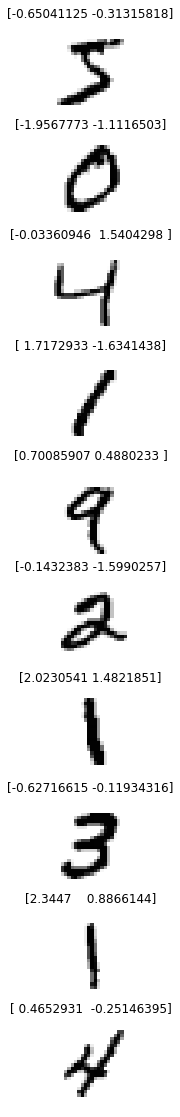

In [ ]:
n_images = 10
fig, axs = plt.subplots(n_images, 1, figsize=(20, 20))

for i in range(n_images):
    ax = axs[i]
    ax.imshow(x_train_cnn[i][:, :, 0], cmap='binary')
    ax.axis('off')
    ax.set_title(f'{latent_represenation[i, :]}')

Or of all images

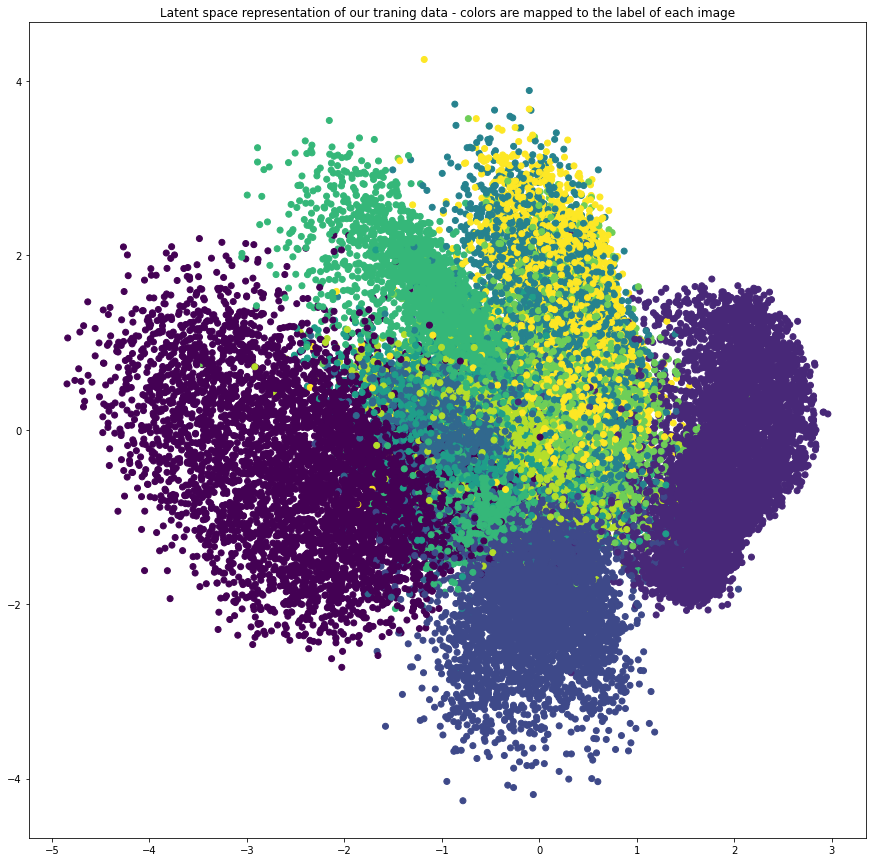

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_represenation[:, 0], latent_represenation[:, 1], c=y_train)
plt.title("Latent space representation of our traning data - colors are mapped to the label of each image");

We can see that albeit the autoencoder never got any labels of our digits during training (input was the handdrawn digit and the output was also the handdrawn digit, we never gave the autoencoder the associated label to the ) it already manged to separate the digits only by the structure of its data.

## Generating examples

We have yet only taken a look at the encoder, but we can use the encoder as well to generate new examples that are not from our traning or data set.
We can simply generate new random vectors in our latent space and use them as input for our decoder which is trained to generate an image of a handdrawn digit based on its input.

We can not simply create random numbers as they need to be within the domain of our latent space.
We therefore scale our random variables $v$ from $[0.0, 1.0)$ to $[a, b)$ via $(b-a) v + a$.

In [ ]:
min_latent = np.min(latent_represenation, axis=0)
max_latent = np.max(latent_represenation, axis=1)

Random latent space variables
[[-4.07249306 -2.69778185]
 [-4.55051369 -4.14555818]
 [-0.54481805 -1.39656167]
 [-0.46891989 -3.44053033]
 [-1.18153598 -2.17199023]
 [-3.46477448 -3.27422322]
 [-4.40267157 -2.6195751 ]
 [-1.7442712  -2.53586633]
 [-2.85048841 -3.672801  ]
 [-4.2922399  -1.20721419]]


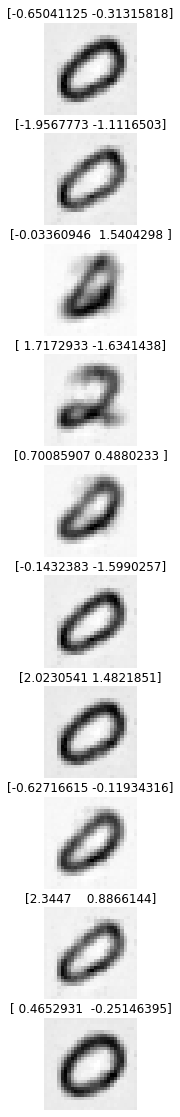

In [ ]:
n_images = 10

first_latent = (max_latent[0] - min_latent[0]) * np.random.random(size=(n_images)) + min_latent[0]
second_latent = (max_latent[1] - min_latent[1]) * np.random.random(size=(n_images)) + min_latent[1]
latent_random = np.column_stack([first_latent, second_latent])
print(f"Random latent space variables\n{latent_random}")

fig, axs = plt.subplots(n_images, 1, figsize=(20, 20))

latent_images = decoder.predict(latent_random)

for i, image in enumerate(latent_images):
    ax = axs[i]
    ax.imshow(image, cmap='binary')
    ax.axis('off')
    ax.set_title(f'{latent_represenation[i, :]}')

We can also sample the latent space and create a map out of it.

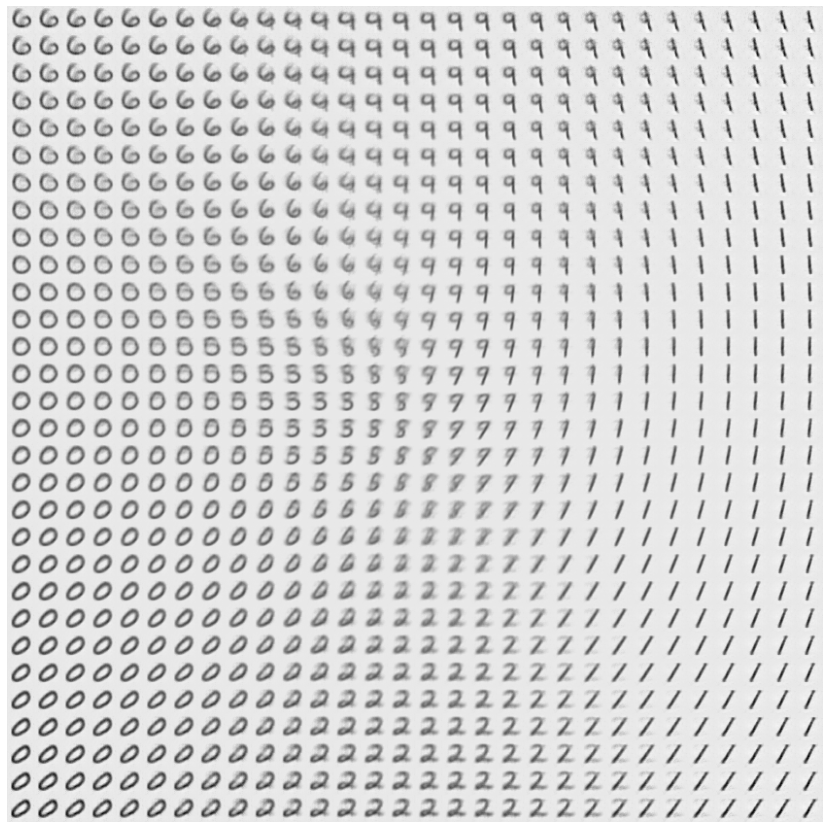

In [ ]:
def plot_latent_space(decoder, n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="binary")
    plt.axis('off')
    plt.show()


plot_latent_space(decoder, scale=3)

How could this be improved? There are techniques such as [variational autoencoders](https://arxiv.org/pdf/1312.6114.pdf) or [VQVAE](https://arxiv.org/pdf/1711.00937.pdf) - vector quantized variational auto encoder.
Those force restrictions on the latent space and therefore allow for more complex data than the handdrawn digits to be re-constructed and generated.
